# Tutorial 1: Feeding a DEM raster to a ConvNet on-the-fly using Spatial Data Generators and TensorFlow2/Keras APIs

In this notebook, you will learn how to feed a remote sensing image to Tensorflow/Keras model by using Spatial Data Generators (SDG). The SDGs will help you feed your remote sensing data as batches with predefined dimensions, without worrying too much about preprocessing your data in advance. SDGs handle the geographic projection and the spatial resolution of your remote sensing data and let you specify your input dimensions as if you are handling a regular image. 

## In order to follow this tutorial, prepare your environment as follows 

1. Create a conda environment with Tensorflow 2 

   conda create -n keras-spatial -c anaconda tensorflow

2. Add matplotlib and Jupyter Lab to the conda environment \
   conda install -c conda-forge matplotlib jupyterlab

3. Install the package by executing the following command\
   pip install git+https://github.com/a2soliman/keras-spatial#egg=keras-spatial 

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from keras_spatial import SpatialDataGenerator

from rasterio.plot import show
from rasterio.crs import CRS

# I. Generating Samples 
## Creating a Spatial Data Generator for DEM

The example we are using is a segmention task of buildings from a high-resolution digitial elevation model (DEM). Input images are 1) DEM and 2) label of building footprints extracted from the Microsoft Building footprint open-access dataset.

First, we start by defining a Spatial Data Generator for the DEM image, let us call it dem, 

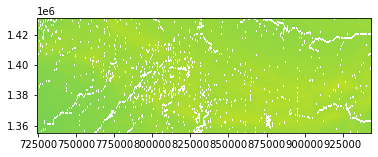

In [2]:
dem_path = './data/aoi_dem_deflate.tif'
dem = SpatialDataGenerator(source=dem_path)
show(dem.src)

## Creating a Spatial Data Generator for labels

Then we create a second Spatial Data Generator for the label; let us call it labels.     

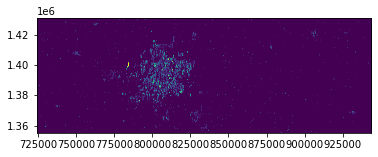

In [3]:
label_path = './data/aoi_label_deflate.tif'
labels = SpatialDataGenerator(source=label_path)
show(labels.src)

## Creating a Sample Space   

The second step is to define a sample space. The Sample sapce splits the satellite image/DEM full extent to equally sized geographic areas that are defined in term of the source image native projected units. For example, here we split the dem full extent into equally sized samples with a width and height of 500 feets. Notice that the units are defined in feet because the DEM has a projection of a EPSG:3443 projection with native units in feet. If your satellite image/DEM projective units are defined in meters then your sample space units are in meters. 

Notice that the sample space is defined in a vector form and it is completely independent from the final resolution deined in pixels. In otherwords, the SDG could resample an area of 100x100 feet or an area of 200X200 feet into a 100 x 100 pixels arrays. This could be used to the advantage of training Neural Nets using a multiscale data with the same input size.       

Created 66000 samples


,geometry
0,"POLYGON ((724380.000 1355444.990, 724380.000 1..."
1,"POLYGON ((724880.057 1355444.990, 724880.057 1..."
2,"POLYGON ((725380.114 1355444.990, 725380.114 1..."
3,"POLYGON ((725880.171 1355444.990, 725880.171 1..."
4,"POLYGON ((726380.228 1355444.990, 726380.228 1..."


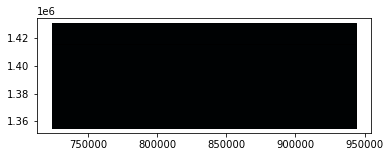

In [4]:
df = dem.regular_grid(500, 500)
print(f'Created {len(df)} samples')

df.plot(color=None, edgecolor='k')
df.head()

By splitting the DEM image into 500 x 500 patches we get 66,000 samples. The samples are saved and maintained in a geo-dataframe to make it easier to select by normal or spatial quieries.

## Selecting a subset of Samples to feed to the ConvNet

Here we performe a spatial query to select only the samples that intersect the boundaries of an urban center, which is defined using an urban_aoi.geojson file. The subset samples is defined using an intersection operation perfomred using the samples geo-dataframe and the area of interest (aoi) shapefile or geojson file.    

### a. Selecting a subset using a Watershed boundaries  

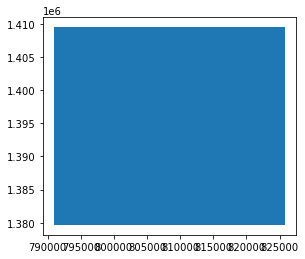

In [5]:
# reading the urban center geometry 
watershed_path = './data/urban_aoi.geojson'
mask = gpd.read_file(watershed_path)
mask.plot()

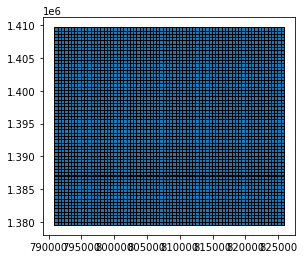

In [6]:
samples = df[df.intersects(mask.unary_union)].copy()
samples.plot(color=None, edgecolor='k')

In [7]:
len(samples)

4200

We end with 4200 samples that intersects the urban center boundaries. 

### b. Selecting a subset using Samples' attributes  

We could also perform a selection of a subset of the samples based on samples attributes. The attributes could be generated using the SDG. For example, we might want to select the samples that have an average elevation within certain range, or select the samples that has no labels at all (negative examples).

In the following example the SDG is used to calculate the sum of each label sample as an indicator of how many label pixels in a sample. Notice that the arrays are generated by the labels SDG and the numpy sum is calculated on-the-fly and stored in a new column in the sample space named features. a 'features' value of zero indicate that the sample has no label pixels in it.     

In [8]:
# adding attributes from the labels 
width, height = 128, 128
samples['features'] = [(np.sum(np.where(arr==1, 0, arr) )) for arr in labels.flow_from_dataframe (samples, width, height, batch_size=1)]
samples.head(1)

,geometry,features
21254,"POLYGON ((791387.631 1379559.352, 791387.631 1...",0.0


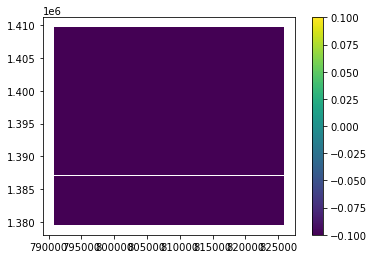

In [9]:
samples.plot(column='features', legend=True)

In the following example we add a new column to the sample space geo-dataframe with the maximum elevation of each sample. In this example the dem SDG is used to generate the samples array at the 128x 128 pixels width and height. The maximum of each sample is calculated using numpy max function, which could be replaced by any other function. 

In [10]:
# adding attributes from the DEM 
samples['elevation'] = [(np.max(arr)) for arr in dem.flow_from_dataframe (samples, width, height, batch_size=1)]
samples.head(1)

,geometry,features,elevation
21254,"POLYGON ((791387.631 1379559.352, 791387.631 1...",0.0,814.690002


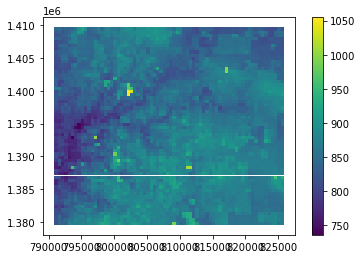

In [11]:
samples.plot(column='elevation', legend=True)

# II. Feeding the Samples to a Neural Net 
## Creating a toy ConvNet model  (TensorFlow 2) 

We start by creating a toy ConvNet model made out of a series of interchaning convolution and activation layers  

In [12]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
# toy convnet model 
model = keras.Sequential()
model.add(keras.Input(shape= (1, 128, 128)))
model.add(layers.Conv2D(1, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(1, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(1, (3, 3), padding="same"))
model.add(layers.Activation('relu'))

In [23]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 128, 1)         1153      
_________________________________________________________________
activation_2 (Activation)    (None, 1, 128, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 128, 1)         10        
_________________________________________________________________
activation_3 (Activation)    (None, 1, 128, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 128, 1)         10        
_________________________________________________________________
activation_4 (Activation)    (None, 1, 128, 1)         0         
Total params: 1,173
Trainable params: 1,173
Non-trainable params: 0
____________________________________________________

In [24]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Connecting Spatial Data Generators to the ConvNet  

We first start by defining the number of samples per batch (32 in this example). Then we estimate the number of steps in a single epoch by estimating the floor division  of (samples per batch)//(total number of samples)

For simplicity, I droped the extra eight samples to obtain a number of samples dividable by number of samples in a single batch (32 samples) without any remaning     

## Remove extra rows from the df 

In [26]:
batch_size = 32
df = samples 

n_steps = len(df)// batch_size # estimate the number of steps given the batch size 
n_extra = len(df) - (batch_size*n_steps) # estimating the number of extra row 
df.drop(df.tail(n_extra).index,inplace = True) # Dropping extra rows 

In [27]:
len(df)

4192

## Combine the images(x) and labels(Y) sgens  

Here we will take advantage of the Tensorflow tf.data APIs to feed our selected sample to the toy ConvNet model. You should notice that the batch_size variable of the SDG is set to one because the tf.data APIs handles the batch size for us. Most likely the option of defining a batch_size within an SDG will be deprecated in the future to avoid confusion.

We will start by instantiating two Dataset objects usig tf.data API for both the dem and the labels rasters. The source of data is the DEM and labels SDG respectively. Notice that a tf Dataset object is a Python iterable. The batch size is defined using tf.data as 32 samples per batch for both SDGs. Notice that the dataset will be repeated mutliple times to match the number of requested epochs. The cache option is added in order to hold the samples after reading them during first epoch in the cache memory and reuse them for subsequent epochs. 

In [28]:
width, height, batch_length, epochs  = 128,128,32,10


x_sgen = dem.flow_from_dataframe(df, width, height, batch_size=1)
datasetx = tf.data.Dataset.from_generator(lambda: map(tuple, x_sgen), (tf.float32))
datasetx = datasetx.batch(batch_length)
datasetx = datasetx.cache().repeat(epochs)

y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
datasety = datasety.batch(batch_length)
datasety = datasety.cache().repeat(epochs)


After defining both dem and labels datasets we will zip them before feeding them directly to the ConvNet model.

In [29]:
dataset = zip(datasetx, datasety)

In [30]:
model.fit( 
            dataset,
            steps_per_epoch=int(n_steps),
            epochs=epochs 
)

Epoch 1/10
131/131 [==============================] - 211s 2s/step - loss: 2.3293 - accuracy: 0.8484
Epoch 2/10
131/131 [==============================] - 3s 23ms/step - loss: 1.9238 - accuracy: 0.8750
Epoch 3/10
131/131 [==============================] - 3s 22ms/step - loss: 1.8761 - accuracy: 0.8781
Epoch 4/10
131/131 [==============================] - 3s 23ms/step - loss: 1.8761 - accuracy: 0.8781
Epoch 5/10
131/131 [==============================] - 3s 24ms/step - loss: 1.8548 - accuracy: 0.8795
Epoch 6/10
131/131 [==============================] - 4s 29ms/step - loss: 1.8515 - accuracy: 0.8797
Epoch 7/10
131/131 [==============================] - 3s 26ms/step - loss: 1.8347 - accuracy: 0.8808
Epoch 8/10
131/131 [==============================] - 3s 26ms/step - loss: 1.7263 - accuracy: 0.8879
Epoch 9/10
131/131 [==============================] - 3s 24ms/step - loss: 1.6584 - accuracy: 0.8924
Epoch 10/10
131/131 [==============================] - 3s 24ms/step - loss: 1.6439 - accura

Notice the longer time spent processing the first epoch in comparison to the time spent on the subsequent ones.

## Display examples

Here, we visuilize examples of the DEM and labels samples for debugging purpose. 

In [31]:
width, height, batch_length, epochs  = 128,128,32,4


x_sgen = dem.flow_from_dataframe(df, width, height, batch_size=1)
datasetx = tf.data.Dataset.from_generator(lambda: map(tuple, x_sgen), (tf.float32))
datasetx = datasetx.batch(batch_length)
iterator = tf.compat.v1.data.make_one_shot_iterator(datasetx)
x = iterator.get_next()
print(x.shape)

(32, 1, 128, 128)


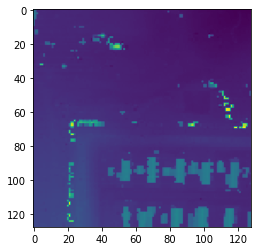

In [32]:
plt.imshow(x[23,0,:,:])

In [33]:
y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
datasety = datasety.batch(batch_length)
iteratory = tf.compat.v1.data.make_one_shot_iterator(datasety)
y = iteratory.get_next()
print(y.shape)

(32, 1, 128, 128)


In [34]:
y_sgen = labels.flow_from_dataframe(df, width, height, batch_size=1)
datasety = tf.data.Dataset.from_generator(lambda: map(tuple, y_sgen), (tf.float32))
datasety = datasety.batch(batch_length)
iteratory = tf.compat.v1.data.make_one_shot_iterator(datasety)
y = iteratory.get_next()
print(y.shape)

(32, 1, 128, 128)


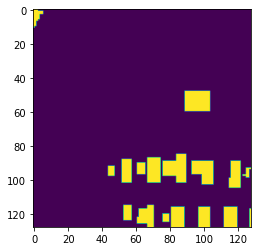

In [35]:
plt.imshow(y[23,0,:,:])

Create a frequency table of the label sample array 

In [36]:

y_tmp = y[23,0,:,:]

unique, counts = np.unique(y_tmp, return_counts=True)

print (np.asarray((unique, counts)).T)

[[0.0000e+00 1.5014e+04]
 [1.0000e+00 1.3700e+03]]


# Following Tutorials
- Splitting training and validation for spatial data 
- Shuffle samples within the training or validation 
- Visualizing intermediate activation layers